In [1]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nltk
import shap
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
train_df = pd.read_csv('./train.csv')
train_df.shape

(20800, 5)

In [3]:
train_df.head(15)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


In [4]:
train_df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

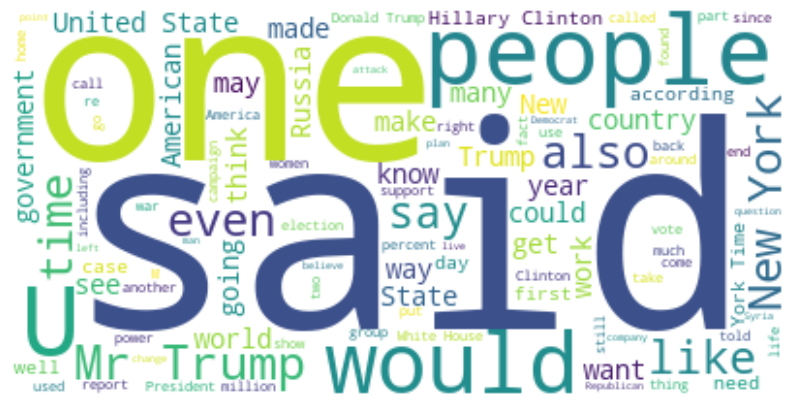

In [5]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the dataset
file_path = './train.csv'
data = pd.read_csv(file_path)

# Combine the text data into a single string
text = ' '.join(data['title'].fillna('') + ' ' + data['text'].fillna(''))

# Predefined list of English stop words
predefined_stopwords = {
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
    'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
    'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
    'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
    'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
    'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
    'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now'
}

# Generate the word cloud
wordcloud = WordCloud(stopwords=predefined_stopwords, max_words=100, background_color="white").generate(text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [6]:
# replacing the null values with empty string
train_df = train_df.fillna('')

In [7]:
# merging the author name and news title
train_df['content'] = train_df['author']+' '+ train_df['title']

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       20800 non-null  int64 
 1   title    20800 non-null  object
 2   author   20800 non-null  object
 3   text     20800 non-null  object
 4   label    20800 non-null  int64 
 5   content  20800 non-null  object
dtypes: int64(2), object(4)
memory usage: 975.1+ KB


In [9]:
# separating the data & label
X = train_df.drop(columns='label', axis=1)
y = train_df['label']

In [10]:
def apply_stemming(content, stemmer):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [stemmer.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [11]:
stemmer = PorterStemmer()
train_df['content'] = train_df['content'].apply(lambda content: apply_stemming(content, stemmer))

In [12]:
print(train_df['content'])

0        darrel lucu hous dem aid even see comey letter...
1        daniel j flynn flynn hillari clinton big woman...
2                   consortiumnew com truth might get fire
3        jessica purkiss civilian kill singl us airstri...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper trump poster child white s...
20796    benjamin hoffman n f l playoff schedul matchup...
20797    michael j de la merc rachel abram maci said re...
20798    alex ansari nato russia hold parallel exercis ...
20799                            david swanson keep f aliv
Name: content, Length: 20800, dtype: object


In [13]:
#separating the features (stemmed contnent) and label
X = train_df['content'].values
y = train_df['label'].values

In [14]:
X.shape

(20800,)

In [15]:
y.shape

(20800,)

In [16]:
# convert text data to its numerical representation
vectorizer = TfidfVectorizer(max_features=9000)
vectorizer.fit(X)

X = vectorizer.transform(X)
X.shape

(20800, 9000)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
# Find optimal hyperparameters using grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2']  # Regularization type
}

# Create a Grid Search with cross-validation
grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5, scoring='accuracy')

# Fit the Grid Search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train a Logistic Regression model with the best hyperparameters
best_logistic_regression = LogisticRegression(solver='liblinear', **best_params)
best_logistic_regression.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_logistic_regression.predict(X_test)

In [19]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

print(f"Best Hyperparameters: {best_params}")
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_report}")

Best Hyperparameters: {'C': 10, 'penalty': 'l1'}
Accuracy: 0.9923076923076923
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2077
           1       0.99      0.99      0.99      2083

    accuracy                           0.99      4160
   macro avg       0.99      0.99      0.99      4160
weighted avg       0.99      0.99      0.99      4160



In [20]:
explainer = shap.Explainer(
    best_logistic_regression, X_train, feature_names=vectorizer.get_feature_names_out()
)
shap_values = explainer(X_test)

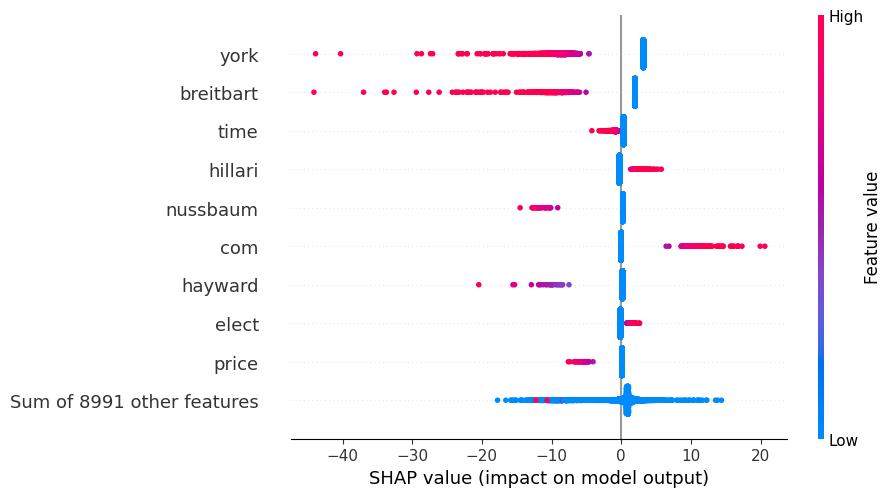

In [21]:
shap.plots.beeswarm(shap_values)

In [25]:
ind = 0
shap.plots.force(shap_values[ind])

In [22]:
from collections import Counter

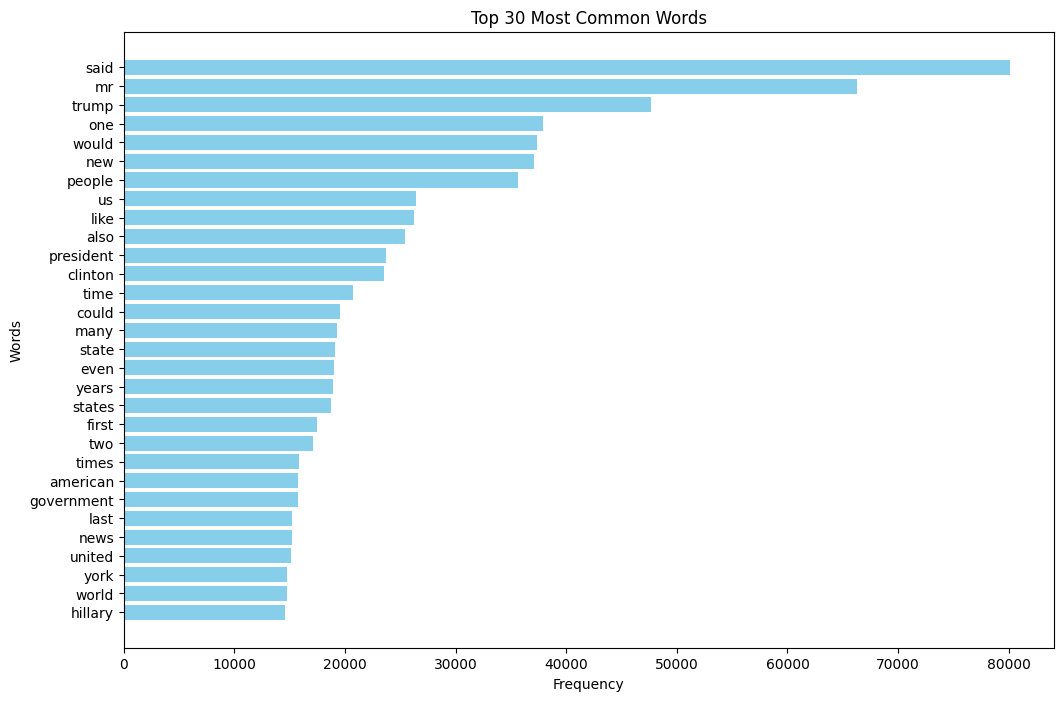

In [23]:
text = ' '.join(data['title'].fillna('') + ' ' + data['text'].fillna(''))

# Predefined list of English stop words
predefined_stopwords = {
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
    'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
    'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
    'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
    'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
    'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
    'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now'
}

# Function to preprocess text: lowercasing, removing special characters, and splitting
def preprocess_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r'[^\w\s]', '', text)  # Removing special characters
    words = text.split()  # Splitting into words
    words = [word for word in words if word not in predefined_stopwords]  # Removing stopwords
    return words

# Preprocess the text data
words = preprocess_text(text)

# Count word frequencies
word_counts = Counter(words)

# Get the most common words
most_common_words = word_counts.most_common(30)  # Adjust the number to display more or fewer words

# Separate the words and their frequencies for plotting
words, counts = zip(*most_common_words)

# Generate the histogram
plt.figure(figsize=(12, 8))
plt.barh(words, counts, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 30 Most Common Words')
plt.gca().invert_yaxis()  # Invert y-axis to have the most frequent word at the top
plt.show()